##Downloading FashionMNIST Dataset

In [ ]:
import torchvision
import torch
data_folder = 'data/FMNIST' # This can be any directory
# you want to download FMNIST to
fmnist = torchvision.datasets.FashionMNIST(data_folder, download=True, train=True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FMNIST/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FMNIST/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FMNIST/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FMNIST/FashionMNIST/raw



In [ ]:
tr_images = fmnist.data
tr_targets = fmnist.targets

In [ ]:
unique_values = tr_targets.unique()
print(f'tr_images & tr_targets:\n\tX -{tr_images.shape}\n\tY \
-{tr_targets.shape}\n\tY-Unique Values : {unique_values}')
print(f'TASK:\n\t{len(unique_values)} class Classification')
print(f'UNIQUE CLASSES:\n\t{fmnist.classes}')

tr_images & tr_targets:
	X -torch.Size([60000, 28, 28])
	Y -torch.Size([60000])
	Y-Unique Values : tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
TASK:
	10 class Classification
UNIQUE CLASSES:
	['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


##Visualization

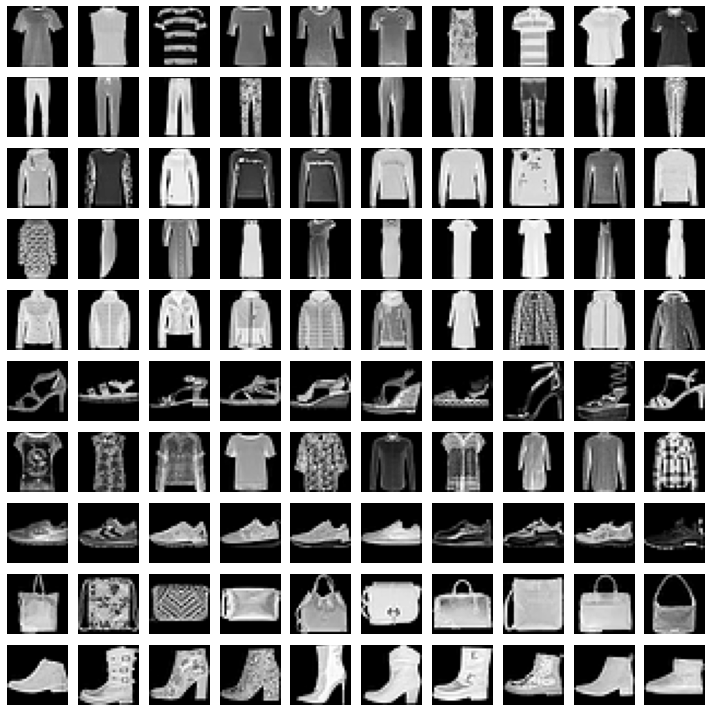

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

R, C = len(tr_targets.unique()), 10
fig, ax = plt.subplots(R, C, figsize=(10,10))
for label_class, plot_row in enumerate(ax):
  label_x_rows = np.where(tr_targets == label_class)[0]
  for plot_cell in plot_row:
    plot_cell.grid(False); plot_cell.axis('off')
    ix = np.random.choice(label_x_rows)
    x, y = tr_images[ix], tr_targets[ix]
    plot_cell.imshow(x, cmap='gray')
plt.tight_layout()

##DataLoader

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torch import nn

device =  'cuda' if torch.cuda.is_available() else 'cpu'

class FMNISTDataset(Dataset):
  def __init__(self, x, y, device):
    self.device = device
    x = x.float()
    x = x.view(-1, 28*28)
    self.x = x
    self.y = y

  def __getitem__(self, ix):
    x = self.x[ix].to(self.device)
    y = self.y[ix].to(self.device)
    return x, y
  
  def __len__(self):
    return len(self.x)

In [ ]:
def get_data(tr_images, tr_targets, device):
  training_data = FMNISTDataset(tr_images, tr_targets, device)
  batch = DataLoader(training_data, batch_size=32, shuffle=True)
  return batch

##Build Model

In [ ]:
from torch.nn.modules.activation import ReLU
from torch.optim import SGD

def get_model(device):
  model = nn.Sequential(
      nn.Linear(28*28, 1000),
      nn.ReLU(),
      nn.Linear(1000, 10)
  )
  model = model.to(device)
  loss_fn = nn.CrossEntropyLoss()
  optimizer = SGD(model.parameters(), lr=1e-2)
  return model, loss_fn, optimizer

In [ ]:
def train_batch(x, y, model, opt, loss_fn):
    model.train()
    prediction = model(x)
    # compute loss
    batch_loss = loss_fn(prediction, y)

    # based on the forward pass in `model(x)` compute all the
    # gradients of 'model.parameters()'
    batch_loss.backward()
    opt.step()

    # Flush gradients memory for next batch of calculations
    opt.zero_grad()
    return batch_loss.item()

@torch.no_grad()
def accuracy(x, y, model):
  model.eval() # <- let's wait till we get to dropout
  # section
  # get the prediction matrix for a tensor of `x` images
  prediction = model(x)
  # compute if the location of maximum in each row
  # coincides with ground truth
  max_values, argmaxes = prediction.max(-1)
  is_correct = argmaxes == y
  return is_correct.cpu().numpy().tolist()

##Start Training

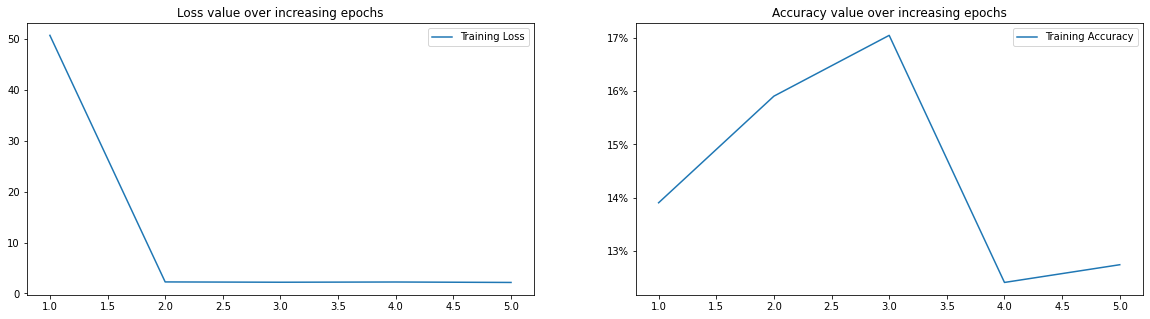

In [ ]:
trn_dl = get_data(tr_images, tr_targets, device)
model, loss_fn, optimizer = get_model(device)
losses, accuracies = [], []
for epoch in range(5):
  epoch_losses, epoch_accuracies = [], []
  for ix, batch in enumerate(iter(trn_dl)):
    x, y = batch
    batch_loss = train_batch(x, y, model, optimizer, loss_fn)
    epoch_losses.append(batch_loss)
  epoch_loss = np.array(epoch_losses).mean()
  for ix, batch in enumerate(iter(trn_dl)):
    x, y = batch
    is_correct = accuracy(x, y, model)
    epoch_accuracies.extend(is_correct)
  epoch_accuracy = np.mean(epoch_accuracies)
  losses.append(epoch_loss)
  accuracies.append(epoch_accuracy)

epochs = np.arange(5)+1
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.title('Loss value over increasing epochs')
plt.plot(epochs, losses, label='Training Loss')
plt.legend()
plt.subplot(122)
plt.title('Accuracy value over increasing epochs')
plt.plot(epochs, accuracies, label='Training Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) \
for x in plt.gca().get_yticks()])
plt.legend()

##Scaling

In [ ]:
class FMNISTDataset(Dataset):
  def __init__(self, x, y, device):
    self.device = device
    x = x.float()/255
    x = x.view(-1, 28*28)
    self.x = x
    self.y = y

  def __getitem__(self, ix):
    x = self.x[ix].to(self.device)
    y = self.y[ix].to(self.device)
    return x, y
  
  def __len__(self):
    return len(self.x)

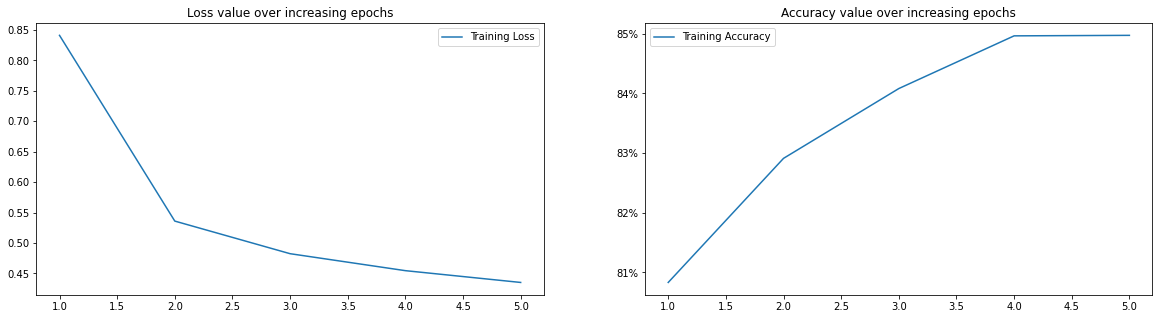

In [ ]:
trn_dl = get_data(tr_images, tr_targets, device)
model, loss_fn, optimizer = get_model(device)
losses, accuracies = [], []
for epoch in range(5):
  epoch_losses, epoch_accuracies = [], []
  for ix, batch in enumerate(iter(trn_dl)):
    x, y = batch
    batch_loss = train_batch(x, y, model, optimizer, loss_fn)
    epoch_losses.append(batch_loss)
  epoch_loss = np.array(epoch_losses).mean()
  for ix, batch in enumerate(iter(trn_dl)):
    x, y = batch
    is_correct = accuracy(x, y, model)
    epoch_accuracies.extend(is_correct)
  epoch_accuracy = np.mean(epoch_accuracies)
  losses.append(epoch_loss)
  accuracies.append(epoch_accuracy)

epochs = np.arange(5)+1
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.title('Loss value over increasing epochs')
plt.plot(epochs, losses, label='Training Loss')
plt.legend()
plt.subplot(122)
plt.title('Accuracy value over increasing epochs')
plt.plot(epochs, accuracies, label='Training Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) \
for x in plt.gca().get_yticks()])
plt.legend()

##Impact of Batch size

###Download validation Data

In [ ]:
val_fmnist = torchvision.datasets.FashionMNIST(data_folder,download=True, train=False)
val_images = val_fmnist.data
val_targets = val_fmnist.targets

In [ ]:
def get_data():
  train = FMNISTDataset(tr_images, tr_targets, device)
  trn_dl = DataLoader(train, batch_size=32, shuffle=True)
  val = FMNISTDataset(val_images, val_targets, device)
  val_dl = DataLoader(val, batch_size=len(val_images), shuffle=False)
  return trn_dl, val_dl

In [ ]:
@torch.no_grad()
def val_loss(x, y, model):
  model.eval()
  prediction = model(x)
  val_loss = loss_fn(prediction, y)
  return val_loss.item()

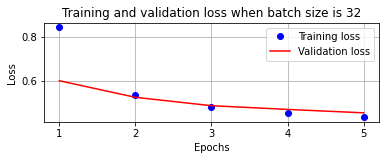

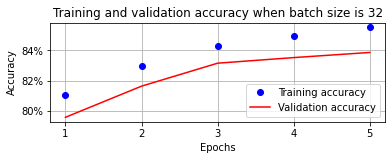

In [ ]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model(device)

train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(5):
  epoch_losses, epoch_accuracies = [], []
  for ix, batch in enumerate(iter(trn_dl)):
    x, y = batch
    batch_loss = train_batch(x, y, model, optimizer, loss_fn)
    epoch_losses.append(batch_loss)
  epoch_loss = np.array(epoch_losses).mean()
  for ix, batch in enumerate(iter(trn_dl)):
    x, y = batch
    is_correct = accuracy(x, y, model)
    epoch_accuracies.extend(is_correct)
  epoch_accuracy = np.mean(epoch_accuracies)
  train_losses.append(epoch_loss)
  train_accuracies.append(epoch_accuracy)

  for ix, batch in enumerate(iter(val_dl)):
    x, y = batch
    val_is_correct = accuracy(x, y, model)
    validation_loss = val_loss(x, y, model)
  val_epoch_accuracy = np.mean(val_is_correct)
  val_losses.append(validation_loss)
  val_accuracies.append(val_epoch_accuracy)

epochs = np.arange(5)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss \
when batch size is 32')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', \
label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', \
label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy \
when batch size is 32')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) \
for x in plt.gca().get_yticks()])
plt.legend()
plt.grid('off')
plt.show()

###Using different Batch size (1000)

In [ ]:
def get_data():
  train = FMNISTDataset(tr_images, tr_targets, device)
  trn_dl = DataLoader(train, batch_size=1000, shuffle=True)
  val = FMNISTDataset(val_images, val_targets, device)
  val_dl = DataLoader(val, batch_size=len(val_images), shuffle=False)
  return trn_dl, val_dl

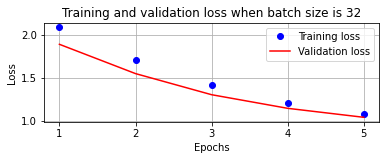

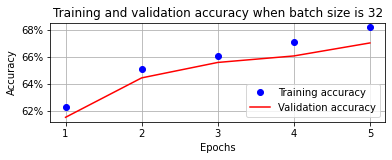

In [ ]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model(device)

train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(5):
  epoch_losses, epoch_accuracies = [], []
  for ix, batch in enumerate(iter(trn_dl)):
    x, y = batch
    batch_loss = train_batch(x, y, model, optimizer, loss_fn)
    epoch_losses.append(batch_loss)
  epoch_loss = np.array(epoch_losses).mean()
  for ix, batch in enumerate(iter(trn_dl)):
    x, y = batch
    is_correct = accuracy(x, y, model)
    epoch_accuracies.extend(is_correct)
  epoch_accuracy = np.mean(epoch_accuracies)
  train_losses.append(epoch_loss)
  train_accuracies.append(epoch_accuracy)

  for ix, batch in enumerate(iter(val_dl)):
    x, y = batch
    val_is_correct = accuracy(x, y, model)
    validation_loss = val_loss(x, y, model)
  val_epoch_accuracy = np.mean(val_is_correct)
  val_losses.append(validation_loss)
  val_accuracies.append(val_epoch_accuracy)

epochs = np.arange(5)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss \
when batch size is 32')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', \
label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', \
label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy \
when batch size is 32')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) \
for x in plt.gca().get_yticks()])
plt.legend()
plt.grid('off')
plt.show()

##The impact of varying the loss optimizer

###SGD

In [ ]:
def get_model(device):
  model = nn.Sequential(
      nn.Linear(28*28, 1000),
      nn.ReLU(),
      nn.Linear(1000, 10)
  )
  model = model.to(device)
  loss_fn = nn.CrossEntropyLoss()
  optimizer = SGD(model.parameters(), lr=1e-2)
  return model, loss_fn, optimizer

In [ ]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
epochs = np.arange(1, 11)
for epoch in range(10):
  train_epoch_losses, train_epoch_accuracies = [], []
  for ix, batch in enumerate(iter(trn_dl)):
    x, y = batch
    batch_loss = train_batch(x, y, model, optimizer, loss_fn)
    train_epoch_losses.append(batch_loss)
    is_correct = accuracy(x, y, model)
    train_epoch_accuracies.extend(is_correct)
  train_epoch_loss = np.array(train_epoch_losses).mean()
  train_epoch_accuracy = np.mean(train_epoch_accuracies)

  for ix, batch in enumerate(iter(val_dl)):
    x, y = batch
    val_is_correct = accuracy(x, y, model)
    validation_loss = val_loss(x, y, model)
  val_epoch_accuracy = np.mean(val_is_correct)
  train_losses.append(train_epoch_loss)
  train_accuracies.append(train_epoch_accuracy)
  val_losses.append(validation_loss)
  val_accuracies.append(val_epoch_accuracy)

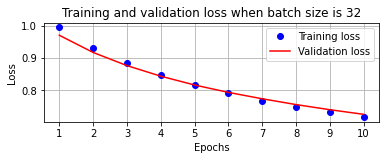

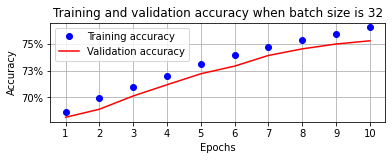

In [ ]:
plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss \
when batch size is 32')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()

plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', \
label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', \
label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy \
when batch size is 32')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) \
for x in plt.gca().get_yticks()])
plt.legend()
plt.grid('off')
plt.show()

###Adam

In [ ]:
from torch.optim import Adam
def get_model(device):
  model = nn.Sequential(
      nn.Linear(28*28, 1000),
      nn.ReLU(),
      nn.Linear(1000, 10)
  )
  model = model.to(device)
  loss_fn = nn.CrossEntropyLoss()
  optimizer = Adam(model.parameters(), lr=1e-2)
  return model, loss_fn, optimizer

In [ ]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(10):
  train_epoch_losses, train_epoch_accuracies = [], []
  for ix, batch in enumerate(iter(trn_dl)):
    x, y = batch
    batch_loss = train_batch(x, y, model, optimizer, loss_fn)
    train_epoch_losses.append(batch_loss)
    is_correct = accuracy(x, y, model)
    train_epoch_accuracies.extend(is_correct)
  train_epoch_loss = np.array(train_epoch_losses).mean()
  train_epoch_accuracy = np.mean(train_epoch_accuracies)

  for ix, batch in enumerate(iter(val_dl)):
    x, y = batch
    val_is_correct = accuracy(x, y, model)
    validation_loss = val_loss(x, y, model)
  val_epoch_accuracy = np.mean(val_is_correct)
  train_losses.append(train_epoch_loss)
  train_accuracies.append(train_epoch_accuracy)
  val_losses.append(validation_loss)
  val_accuracies.append(val_epoch_accuracy)

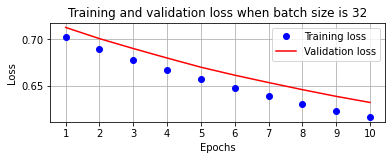

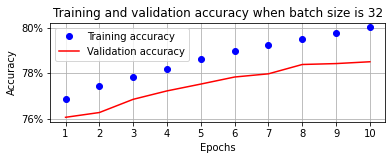

In [ ]:
plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss \
when batch size is 32')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()

plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', \
label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', \
label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy \
when batch size is 32')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) \
for x in plt.gca().get_yticks()])
plt.legend()
plt.grid('off')
plt.show()

##Learning Rate

###Impact of the learning rate on a scaled dataset

#### We used in the previouse section learning rate 0.1
#### Here we use 0.001

In [ ]:
def get_model():
  model = nn.Sequential(
  nn.Linear(28 * 28, 1000),
  nn.ReLU(),
  nn.Linear(1000, 10)
  ).to(device)
  loss_fn = nn.CrossEntropyLoss()
  [ 129 ]
  optimizer = Adam(model.parameters(), lr=1e-3)
  return model, loss_fn, optimizer

In [ ]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(10):
  train_epoch_losses, train_epoch_accuracies = [], []
  for ix, batch in enumerate(iter(trn_dl)):
    x, y = batch
    batch_loss = train_batch(x, y, model, optimizer, loss_fn)
    train_epoch_losses.append(batch_loss)
    is_correct = accuracy(x, y, model)
    train_epoch_accuracies.extend(is_correct)
  train_epoch_loss = np.array(train_epoch_losses).mean()
  train_epoch_accuracy = np.mean(train_epoch_accuracies)

  for ix, batch in enumerate(iter(val_dl)):
    x, y = batch
    val_is_correct = accuracy(x, y, model)
    validation_loss = val_loss(x, y, model)
  val_epoch_accuracy = np.mean(val_is_correct)
  train_losses.append(train_epoch_loss)
  train_accuracies.append(train_epoch_accuracy)
  val_losses.append(validation_loss)
  val_accuracies.append(val_epoch_accuracy)

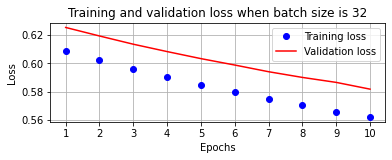

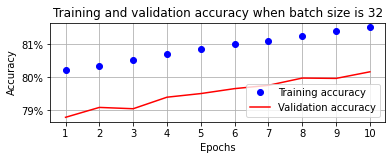

In [ ]:
plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss \
when batch size is 32')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()

plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', \
label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', \
label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy \
when batch size is 32')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) \
for x in plt.gca().get_yticks()])
plt.legend()
plt.grid('off')
plt.show()

#### Here we use 0.00001

In [32]:
def get_model():
  model = nn.Sequential(
  nn.Linear(28 * 28, 1000),
  nn.ReLU(),
  nn.Linear(1000, 10)
  ).to(device)
  loss_fn = nn.CrossEntropyLoss()
  [ 129 ]
  optimizer = Adam(model.parameters(), lr=1e-5)
  return model, loss_fn, optimizer

In [35]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(100):
  train_epoch_losses, train_epoch_accuracies = [], []
  for ix, batch in enumerate(iter(trn_dl)):
    x, y = batch
    batch_loss = train_batch(x, y, model, optimizer, loss_fn)
    train_epoch_losses.append(batch_loss)
    is_correct = accuracy(x, y, model)
    train_epoch_accuracies.extend(is_correct)
  train_epoch_loss = np.array(train_epoch_losses).mean()
  train_epoch_accuracy = np.mean(train_epoch_accuracies)

  for ix, batch in enumerate(iter(val_dl)):
    x, y = batch
    val_is_correct = accuracy(x, y, model)
    validation_loss = val_loss(x, y, model)
  val_epoch_accuracy = np.mean(val_is_correct)
  train_losses.append(train_epoch_loss)
  train_accuracies.append(train_epoch_accuracy)
  val_losses.append(validation_loss)
  val_accuracies.append(val_epoch_accuracy)

In [37]:
epochs = np.arange(1, 101)

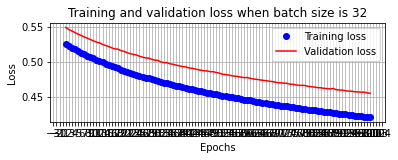

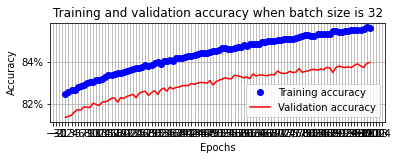

In [38]:
plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss \
when batch size is 32')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()

plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', \
label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', \
label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy \
when batch size is 32')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) \
for x in plt.gca().get_yticks()])
plt.legend()
plt.grid('off')
plt.show()

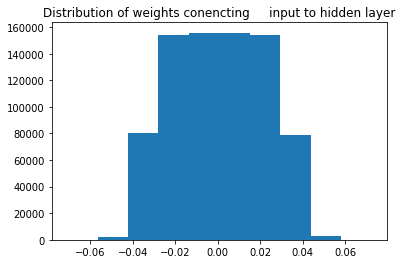

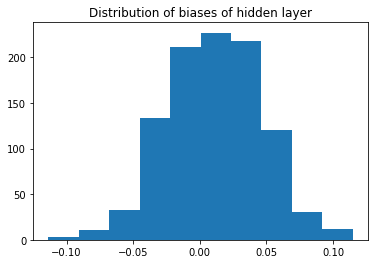

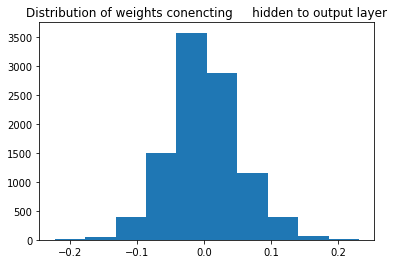

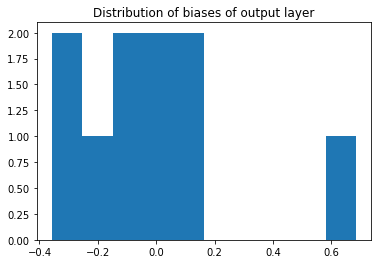

In [39]:
for ix, par in enumerate(model.parameters()):
  if(ix==0):
    plt.hist(par.cpu().detach().numpy().flatten())
    plt.title('Distribution of weights conencting \
    input to hidden layer')
    plt.show()
  elif(ix ==1):
    plt.hist(par.cpu().detach().numpy().flatten())
    plt.title('Distribution of biases of hidden layer')
    plt.show()
  elif(ix==2):
    plt.hist(par.cpu().detach().numpy().flatten())
    plt.title('Distribution of weights conencting \
    hidden to output layer')
    plt.show()
  elif(ix ==3):
    plt.hist(par.cpu().detach().numpy().flatten())
    plt.title('Distribution of biases of output layer')
    plt.show()

***Here, we can see the following:***
1.   ***When the learning rate is high, parameters have a much larger distribution compared to medium and low learning rates.***
2.   ***When parameters have a bigger distribution, overfitting occurs.***

##Scheduler

In [40]:
from torch.optim import lr_scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,
          factor=0.5,patience=0,
          threshold = 0.001,
          verbose=True,
          min_lr = 1e-5,
          threshold_mode = 'abs')

In [42]:
def get_model():
  model = nn.Sequential(
  nn.Linear(28 * 28, 1000),
  nn.ReLU(),
  nn.Linear(1000, 10)).to(device)
  loss_fn = nn.CrossEntropyLoss()
  optimizer = Adam(model.parameters(), lr=1e-3)
  return model, loss_fn, optimizer

In [43]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(50):
  train_epoch_losses, train_epoch_accuracies = [], []
  for ix, batch in enumerate(iter(trn_dl)):
    x, y = batch
    batch_loss = train_batch(x, y, model, optimizer, loss_fn)
    train_epoch_losses.append(batch_loss)
    is_correct = accuracy(x, y, model)
    train_epoch_accuracies.extend(is_correct)
  train_epoch_loss = np.array(train_epoch_losses).mean()
  train_epoch_accuracy = np.mean(train_epoch_accuracies)

  for ix, batch in enumerate(iter(val_dl)):
    x, y = batch
    val_is_correct = accuracy(x, y, model)
    validation_loss = val_loss(x, y, model)
    scheduler.step(validation_loss)
  val_epoch_accuracy = np.mean(val_is_correct)
  train_losses.append(train_epoch_loss)
  train_accuracies.append(train_epoch_accuracy)
  val_losses.append(validation_loss)
  val_accuracies.append(val_epoch_accuracy)

Epoch 00002: reducing learning rate of group 0 to 5.0000e-03.
Epoch 00003: reducing learning rate of group 0 to 2.5000e-03.
Epoch 00004: reducing learning rate of group 0 to 1.2500e-03.
Epoch 00005: reducing learning rate of group 0 to 6.2500e-04.
Epoch 00006: reducing learning rate of group 0 to 3.1250e-04.
Epoch 00007: reducing learning rate of group 0 to 1.5625e-04.
Epoch 00008: reducing learning rate of group 0 to 7.8125e-05.
Epoch 00009: reducing learning rate of group 0 to 3.9063e-05.
Epoch 00010: reducing learning rate of group 0 to 1.9531e-05.
Epoch 00011: reducing learning rate of group 0 to 1.0000e-05.


In [45]:
epochs = np.arange(1, 51)

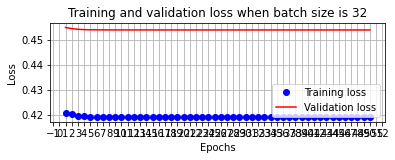

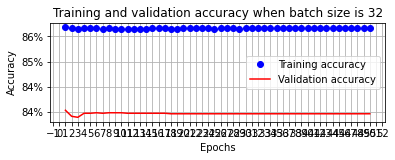

In [48]:
plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss \
when batch size is 32')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()

plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', \
label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', \
label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy \
when batch size is 32')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) \
for x in plt.gca().get_yticks()])
plt.legend()
plt.grid('off')
plt.show()

In [49]:
def get_model():
  model = nn.Sequential(
  nn.Linear(28 * 28, 1000),
  nn.ReLU(),
  nn.Linear(1000, 1000),
  nn.ReLU(),
  nn.Linear(1000, 10) ).to(device)
  loss_fn = nn.CrossEntropyLoss()
  optimizer = Adam(model.parameters(), lr=1e-3)
  return model, loss_fn, optimizer

***Regularization*** is a technique in which we penalize the model for having high weight values. Hence, it is a dual objective function – minimize the loss of training data, as well as the weight values.